# **Covid-19 Aprendizagem Supervisionada**
#### Faculdade de Engenharia da Universidade do Porto
#### Inteligência Artificial
* Ana Macedo
* Eduardo Campos
* Miguel Gomes


## **Resumo (abstract?)**
abstract text

## **Introdução**
Descricao do projeto no geral

## **Descrição do problema e datasets**
Descricao dos dados recebidos

## **Approach**
Breve texto com as ideias iniciais e explicação do preprocessamento

### **Pré-processamento**

#### **Remoção de valores nulos e coluna redundante iso**

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
import math
import datetime
import matplotlib.pyplot as plt
from sklearn import tree, preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error 

covid_dataset = pd.read_csv('google_new.csv', na_values=['NA'])

#Searching for null values, none found
print(covid_dataset.isnull().sum())
#covid_dataset = covid_dataset[covid_dataset['total_cases'] > 0]
covid_dataset.drop('iso', axis=1, inplace=True)

iso                  0
country              0
date                 0
grocery_pharmacy     0
parks                0
residential          0
retail_recreation    0
transit_stations     0
workplaces           0
total_cases          0
fatalities           0
dtype: int64


#### **Adição de coluna *recovered_cases***

In [5]:
#Recovered cases data retrieved from this repository: https://github.com/imdevskp/covid_19_jhu_data_web_scrap_and_cleaning)

recv_df = pd.read_csv('time_series_covid19_recovered_global.csv')
   
#Removing column Province/State
recv_df.drop('Province/State', axis=1, inplace=True)

#summing province/state values in only one country
dates = recv_df.columns[4:]
recovered=recv_df.groupby(['Country/Region'], as_index=False)[dates].sum()

#changing the date format of the our data to match the retrieved data 
covid_dataset['date']= pd.to_datetime(covid_dataset.date)
covid_dataset['date'] = covid_dataset['date'].dt.strftime('%m/%d/%Y')

#changing the format of the retrieved dataframe, passing the dates to rows instead of columns, to be able to join with our dataframe
recv_df_long = recovered.melt(id_vars=['Country/Region'],value_vars=dates, var_name='date', value_name='Recovered')
recv_df_long= recv_df_long.rename(columns={'Country/Region': 'country'})
recv_df_long= recv_df_long.rename(columns={'Recovered': 'recovered'})
#Joining the two dataframes

new_covid_dataset = pd.merge(left=covid_dataset, right=recv_df_long, on=['country', 'date']) 
print(new_covid_dataset.loc[:, ['recovered', 'country']])

recovered       country
0            0     Argentina
1            0     Argentina
2            0     Argentina
3            0     Argentina
4            0     Argentina
..         ...           ...
812         50  South Africa
813         50  South Africa
814         95  South Africa
815         95  South Africa
816         95  South Africa

[817 rows x 2 columns]


#### **Adiçao da coluna *passed_days***

In [6]:
#List of all countries in dataset
countries = new_covid_dataset['country'].unique()

#passed_days is the number of passed days since the first reported day with more than 0 cases
#passed days column
new_covid_dataset['date']= pd.to_datetime(new_covid_dataset.date)
for country in countries:
    country_rows = new_covid_dataset[new_covid_dataset['country'] == country]
    new_covid_dataset.loc[new_covid_dataset['country'] == country, 'passed_days'] = (country_rows['date'] - country_rows.iloc[0]['date']).dt.days

new_covid_dataset.drop('date', axis=1, inplace=True)
    
print(new_covid_dataset.loc[:, ['passed_days']])

passed_days
0            0.0
1            1.0
2            2.0
3            3.0
4            4.0
..           ...
812         38.0
813         39.0
814         40.0
815         41.0
816         42.0

[817 rows x 1 columns]


#### **Adição de coluna *cases_per_million* e *cases_last_day***

In [7]:
#dict with populations to fill
population = {'Argentina' : 44490000, 'Australia' : 24990000, 'Brazil' : 209500000,
              'Canada' : 37590000, 'Germany' : 83020000, 'Spain' : 46940000, 
              'France' : 66990000, 'United Kingdom' : 66650000, 'Indonesia' : 267700000, 
              'India' : 1353000000, 'Italy' : 60360000, 'Japan' : 126500000, 
              'South Korea' : 51640000, 'Mexico' : 126200000, 'Saudi Arabia' : 33700000, 
              'Sweden' : 10230000, 'Turkey' : 82000000, 'US' : 328200000, 'South Africa' : 57780000}
for country in countries:
    new_covid_dataset.loc[new_covid_dataset['country'] == country, 'population'] = population[country]
    new_covid_dataset.loc[:, 'cases_per_million'] = new_covid_dataset['total_cases']/(new_covid_dataset['population']/1000000)

new_covid_dataset.drop('population', axis=1, inplace=True)

#cases in the previous day
new_covid_dataset['cases_last_day'] = new_covid_dataset['cases_per_million'].shift(1)
new_covid_dataset['cases_last_day'].fillna(0, inplace=True)
#make first row of each country have cases_last_day = 0\n",
for i in range(len(new_covid_dataset)):
    if i != 0 and new_covid_dataset.loc[i, 'country'] != new_covid_dataset.loc[i-1, 'country']:
        new_covid_dataset.loc[i, 'cases_last_day'] = 0

print(new_covid_dataset.loc[:, ['cases_per_million', 'cases_last_day']])
new_covid_dataset.to_csv('result.csv')

cases_per_million  cases_last_day
0             0.000000        0.000000
1             0.000000        0.000000
2             0.000000        0.000000
3             0.000000        0.000000
4             0.000000        0.000000
..                 ...             ...
812          23.883697       23.416407
813          25.302873       23.883697
814          26.047075       25.302873
815          27.431637       26.047075
816          28.643129       27.431637

[817 rows x 2 columns]


### **Visualização de dados iniciais**

#### **Evolução, por país, na frequentação de espaços públicos**

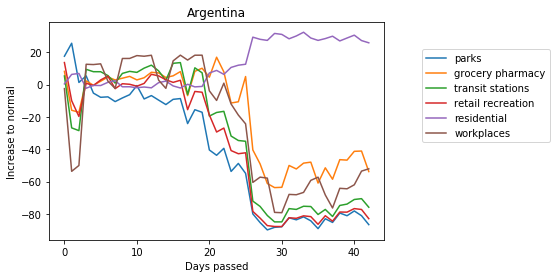

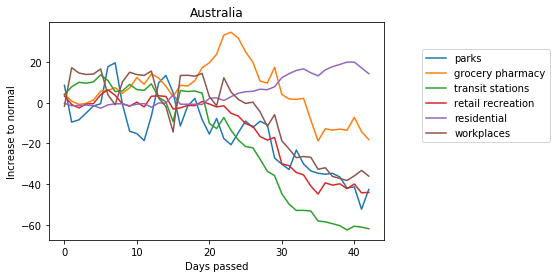

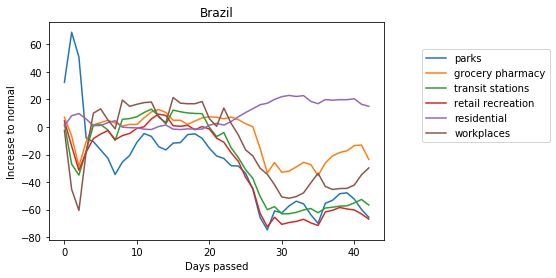

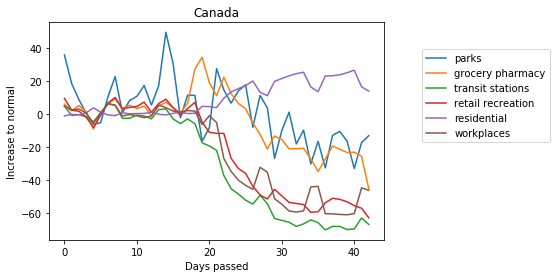

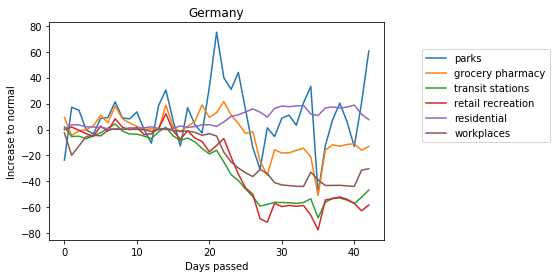

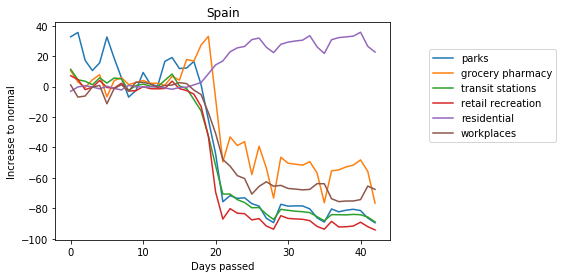

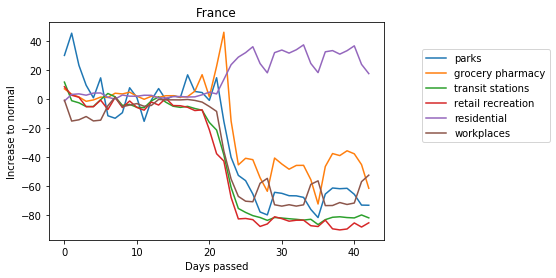

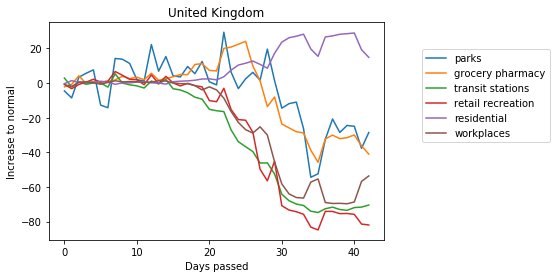

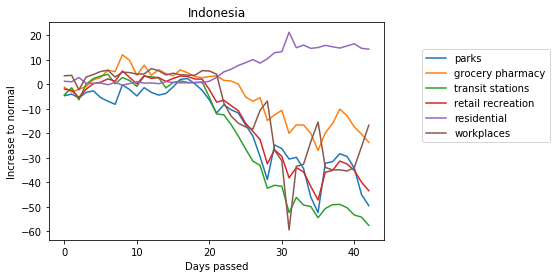

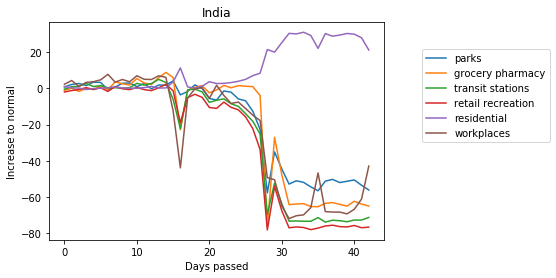

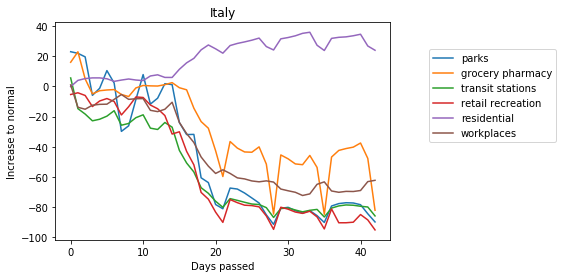

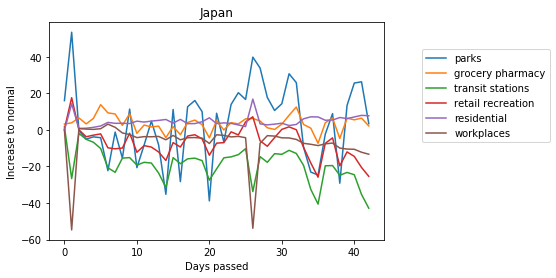

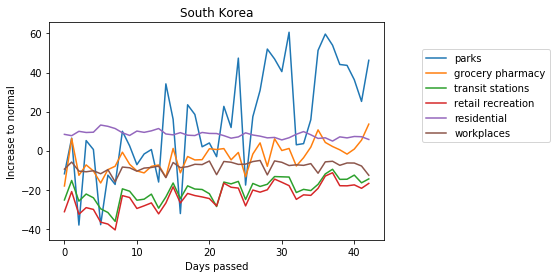

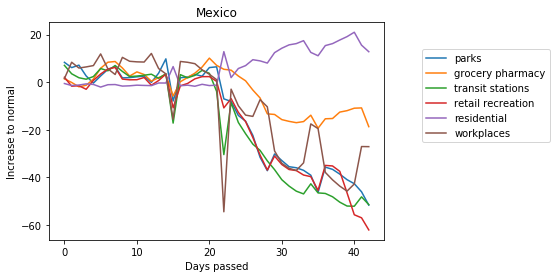

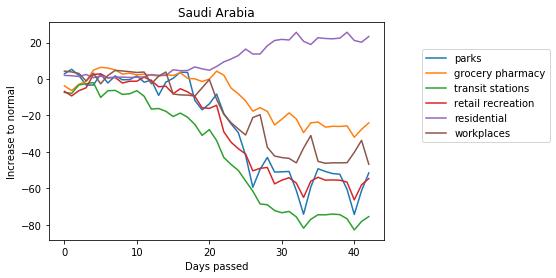

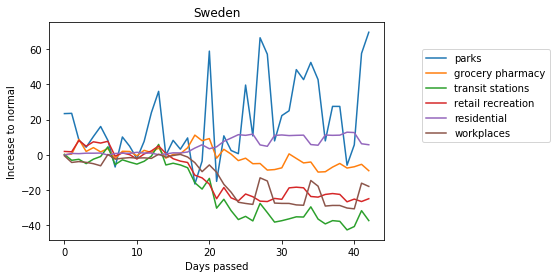

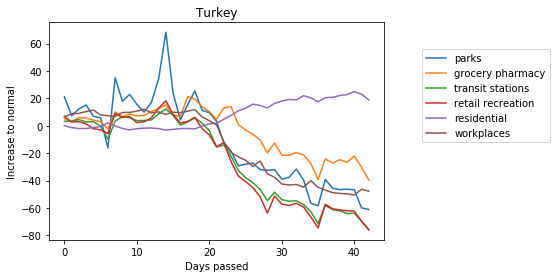

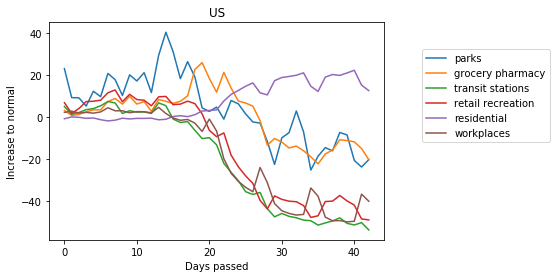

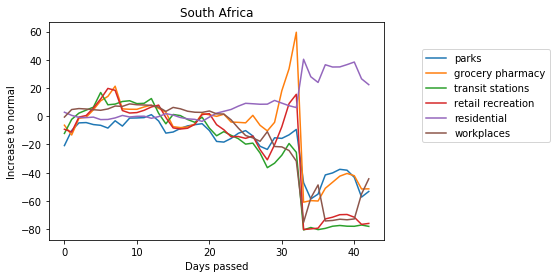

In [8]:
for i in range(0, len(countries)):
    #Rows corresponding to the country in the current iteration
    country_rows = new_covid_dataset[new_covid_dataset['country'] == countries[i]]
    #Plot each of the variables
    plt.plot(country_rows['passed_days'], country_rows['parks'], label='parks')
    plt.plot(country_rows['passed_days'], country_rows['grocery_pharmacy'], label='grocery pharmacy')
    plt.plot(country_rows['passed_days'], country_rows['transit_stations'], label='transit stations')
    plt.plot(country_rows['passed_days'], country_rows['retail_recreation'], label='retail recreation')
    plt.plot(country_rows['passed_days'], country_rows['residential'], label='residential')
    plt.plot(country_rows['passed_days'], country_rows['workplaces'], label='workplaces')
    
    #Title, label and legend
    plt.ylabel('Increase to normal')
    plt.xlabel('Days passed')
    plt.legend(bbox_to_anchor=(1.1, 0.9), loc=2)
    plt.title(countries[i])
    plt.show()

#### **Evolução, por país, do número total de casos confirmados**

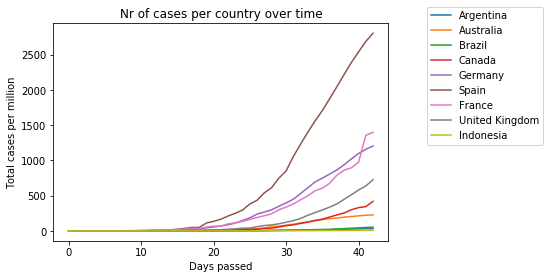

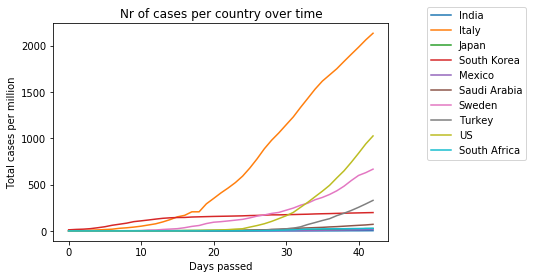

In [9]:
#List of all countries in dataset
countries = covid_dataset['country'].unique()
for i in range(0, (len(countries))//2):
    #Rows corresponding to the country in the current iteration
    country_rows = new_covid_dataset[new_covid_dataset['country'] == countries[i]]
    #Plot total cases
    plt.plot(country_rows['passed_days'], country_rows['cases_per_million'], label=countries[i])
    
#Title, label and legend
plt.ylabel('Total cases per million')
plt.xlabel('Days passed')
plt.legend(bbox_to_anchor=(1.1, 1.1), loc=2)
plt.title('Nr of cases per country over time')
plt.show()

for i in range((len(countries))//2, len(countries)):
    #Rows corresponding to the country in the current iteration
    country_rows = new_covid_dataset[new_covid_dataset['country'] == countries[i]]
    #Plot total cases
    plt.plot(country_rows['passed_days'], country_rows['cases_per_million'], label=countries[i])
    
#Title, label and legend
plt.ylabel('Total cases per million')
plt.xlabel('Days passed')
plt.legend(bbox_to_anchor=(1.1, 1.1), loc=2)
plt.title('Nr of cases per country over time')
plt.show()

## **Avaliação experimental**

### **Decision Trees**

####  **Preprocessing**

In [10]:
le = preprocessing.LabelEncoder()
le.fit(countries)

#DecisionTreeRegressor must take ints/floats, can't take strings, so a dict of name->int is created
countryDict = dict(zip(countries, le.transform(countries)))

inputData = []
outputData = []
for index, row in new_covid_dataset.iterrows():
    inputData.append([
        countryDict[row['country']], row['passed_days']
    ])
    outputData.append([
        float(row['cases_per_million'])
    ])
        
clf = tree.DecisionTreeRegressor()
clf = clf.fit(inputData, outputData)

#### **Visualização de resultados**

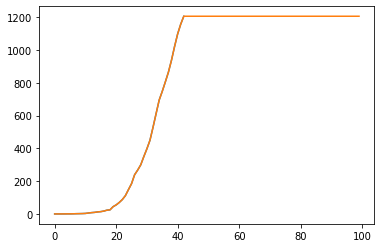

In [11]:
cases = []
passedDays = []
#Temporary, showing prediction for single country
for i in range(100):
    cases.append(clf.predict([[countryDict['Germany'], i]]))
    passedDays.append(i)
    
country_rows = new_covid_dataset[new_covid_dataset['country'] == 'Germany']
#Plot total cases
plt.plot(country_rows['passed_days'], country_rows['cases_per_million'])
plt.plot(passedDays, cases)
plt.show()

In [12]:
le = LabelEncoder()
new_covid_dataset['country'] = le.fit_transform(new_covid_dataset['country'])

In [13]:
new_covid_dataset = new_covid_dataset.drop(columns=['fatalities', 'total_cases'])

# Define country to use by excluding it from training dataset
ct = 2 #<-- change country here

train = new_covid_dataset.drop(new_covid_dataset.loc[new_covid_dataset.country==ct].index);
train.reset_index(drop=True, inplace=True)

x_train = train.drop('cases_per_million', axis=1)
y_train = train['cases_per_million']

test = new_covid_dataset.loc[new_covid_dataset['country'] == ct]
test.reset_index(drop=True, inplace=True)

x_test = test.drop('cases_per_million', axis=1)
y_test = test['cases_per_million']


## **Support Vector Machine**

### **Pré-processamento**

In [14]:
sc_x = StandardScaler()
sc_y = StandardScaler()

x_train = sc_x.fit_transform(x_train)
y_train = sc_y.fit_transform(y_train.values.reshape(-1,1))
x_test = sc_x.transform(x_test)

regressor = SVR()
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.04, epsilon=.05)
svr_lin = SVR(kernel='linear', C=100, gamma='scale')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=1, epsilon=.04, coef0=1)

svrs = [regressor, svr_rbf, svr_lin, svr_poly]

pred_matrix = []

svr_rbf.fit(x_train,y_train.ravel())
y_pred = svr_rbf.predict(x_test)
y_pred = sc_y.inverse_transform(y_pred)


print(list(map('{:.3f}'.format,y_pred)))

error = np.sqrt(mean_squared_error(y_test,y_pred))
print(error)

actual = test

# preserve solution
solution = actual
actual = actual.drop(['cases_per_million'], axis=1)

['15.945', '25.382', '31.902', '3.478', '12.175', '13.262', '12.670', '8.588', '15.592', '13.179', '15.125', '14.241', '14.122', '13.183', '13.742', '19.892', '17.298', '20.147', '18.762', '19.381', '14.556', '12.172', '19.418', '14.738', '14.032', '10.047', '11.207', '2.295', '-3.722', '5.973', '13.721', '17.409', '22.338', '24.657', '22.893', '17.743', '23.932', '31.387', '38.492', '46.629', '56.506', '61.276', '64.400']
13.345460615585619


#### **Visualização de resultados**

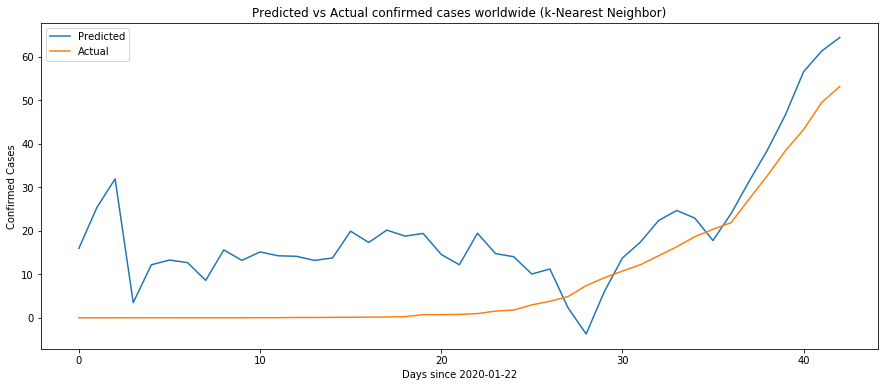

In [15]:
#print(solution)
predict = y_pred
actual['cases_per_million'] = predict
#print(solution)
fig = plt.figure(figsize=(15,6))
sb.lineplot(x='passed_days', y='cases_per_million', label='Predicted', data=actual.groupby(['passed_days'], as_index=False)['cases_per_million'].sum())
ax = sb.lineplot(x='passed_days', y='cases_per_million', label='Actual', data=solution.groupby(['passed_days'], as_index=False)['cases_per_million'].sum())
ax = ax.set(xlabel='Days since 2020-01-22', ylabel='Confirmed Cases', title='Predicted vs Actual confirmed cases worldwide (k-Nearest Neighbor)')

## **k-Nearest Neighbours**
O K-Nearest Neighbour é um algoritmo que pode ser usado tanto em Regressões como em Classificações, onde os resultados são obtidos através da média, que pode ou não ser pesada, dos K vizinhos mais próximos de um ponto, para a(s) variável(is) que se deseja(m) avaliar.

Nos próximos passos, e usando o Dataset fornecido, tentaremos obter os valores para o aumento gradual dos casos de Covid-19 para um qualquer dado país do Dataset.

In [16]:
import pandas as pd;
import numpy as np;

covid = pd.read_csv('google_new.csv');


Inicialmente é necessário manipular um bocado os dados existentes de modo a maximizar a sua utilidade e as informações que nos passam. Desse modo, adicionamos ao Dataset uma coluna com a população de cada país. Esta informação é crucial para podermos calcular os casos por milhão de habitantes de cada país de forma a normalizar um bocado os dados e mitigar possíveis discrepâncias que de outra forma poderiam existir.

Depois de obter os casos por milhão, procedemos também ao calculo dos dias passados desde o início da contabilização. A criação desta coluna é importante por diversas razões, visto que permite ao algoritmo entender a informação dada pela coluna 'Date' (algo que normalmento, sem enconding, não seria possível)mas mais importante permite que este tenha um noção de como o número de casos em cada país evolve com e ao longo do tempo.

Por fim, foi ainda criada uma coluna 'Previous Day' com os casos (por milhão de habitantes) do dia anterior. Esta é uma informação importante pois, juntamente com os Mobility Reports é necessário perceber quantas pessoas no espaço amostral já estavam efetivamente contaminadas, de modo a realmente conseguir perceber como é que a frequentação dos diversos espaços pela população contribui como um fator para o auento/decréscimo do número de casos. De notar que o valor para os casos do dia anterior ao dia 0 foi sempre assumido como sendo 0.

In [17]:
#List of all countries in dataset
countries = covid['country'].unique()

#dict with populations to fill
population = {'Argentina' : 44490000, 'Australia' : 24990000, 'Brazil' : 209500000, 'Canada' : 37590000, 'Germany' : 83020000, 'Spain' : 46940000, 
              'France' : 66990000, 'United Kingdom' : 66650000, 'Indonesia' : 267700000, 'India' : 1353000000, 'Italy' : 60360000, 'Japan' : 126500000, 
              'South Korea' : 51640000, 'Mexico' : 126200000, 'Saudi Arabia' : 33700000, 'Sweden' : 10230000, 'Turkey' : 82000000, 'US' : 328200000, 
              'South Africa' : 57780000}

#passed days column
covid['date']= pd.to_datetime(covid.date)
for country in countries:
    covid.loc[covid['country'] == country, 'population'] = population[country];
    covid.loc[:, 'cases_per_million'] = covid['total_cases']/(covid['population']/1000000.0);
    country_rows = covid[covid['country'] == country]
    covid.loc[covid['country'] == country, 'passed_days'] = (country_rows['date'] - country_rows.iloc[0]['date']).dt.days
    

#cases in the previous day
covid['previous_day'] = covid['cases_per_million'].shift(1)
covid['previous_day'].fillna(0, inplace=True)
for i in range(len(covid)):
    if i != 0 and covid.loc[i, 'country'] != covid.loc[i-1, 'country']:
        covid.loc[i, 'previous_day'] = 0


De seguida, procedemos a um pequeno pré-processamento do Dataset, nomeadamente, da tabela 'Country' de modo a que a informação dos país, previamente uma string inlegível pelos algoritmos, possa ser entendida pelos mesmo e seguidamente utilizada. Para este efeito, usamos um simples Label Encoder sobre a tabela desejada.

In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
covid['country'] = le.fit_transform(covid['country'])


Inicialmente tinhamos planeado fazer uma normalização das diversas tabelas, de modo a que todas as tabelas tivessem os seus respetivos valores entre 0 e 1. No entanto, apesar dos resultados obtidos não serem maus de todo, reparamos que sem a normalização conseguimos obter resultados melhores, pelo que descartamos, para o k-Nearest Neighbour, esse passo de pré-processamento.

De seguida, começamos por remover do Dataset as tabelas que identificamos que são inúteis (ou seja, não aparentam ter influência no resultado final), ou que são redundantes numa tentativa de diminuir o número de fatores a calcular, tornando o algoritmo mais rápido. Adicionalmente, após pesquisa, várias fontes referem que o k-Nearest Neighbour perde alguma eficácia quando possui demasiadas variáveis no seu modelo, pelo que a remoção destas colunas é uma maneira de nos protegermos contra esta posibilidade.

É criado um novo dataframe 'Testing', que consiste num dataframe com todos os países menos aquele que se pretende perver o valor, de forma a não incluir nos dados de treino os dados pelos queremos testar. Note-se que como a coluna dos países foi codificada não se pode pesquisar pelo nome do país. Os valores desta coluna vão agora de 0 a 18, por ordem alfabética, 0 seria Argentina, 18 os Estados Unidos (US no dataset).

Este novo dataframe é depois dividido numa razão 70% para treino e 30% para teste. este split é stratificado sobre a coluna 'Country' de modo a garantir que após os split um dado país se encontre todo ou no training set ou no testing set. A presença do random_state (com o valor 4) é apenas uma seed para a aleatoriedade do split que permite que os resultados sejam reproduzíveis, o que é importante para efeitos de estudo. Neste aspeto, o valor passado é irrelevante.

Depois, quer para o conjunto de treino ou conjunto de teste é necessário remover o coluna que se pretenda prever, guardando-a à parte para comparação futura.

In [20]:

%matplotlib inline
import matplotlib.pyplot as plt;
import seaborn as sb;

# the following tables will not be used, therefore are droped to avoid possible noise
covid = covid.drop(columns=['fatalities', 'date', 'iso', 'population', 'total_cases'])

# train and test sets
from sklearn.model_selection import train_test_split

# Define country to use by excluding it from training/testing dataset

ct = 2 #<-- change country here

testing = covid.drop(covid.loc[covid.country== ct].index);
testing.reset_index(drop=True, inplace=True)

# save country to predict in another variable
pred_country = covid.loc[covid['country'] == ct]

train , test = train_test_split(testing, test_size=0.3, random_state=4, stratify=testing['country'])

x_train = train.drop('cases_per_million', axis=1)
y_train = train['cases_per_million']

x_test = test.drop('cases_per_million', axis = 1)
y_test = test['cases_per_million']


Agora, é onde as coisas começam a ficar interessantes, temos que começar a identificar os parâmetros a usar para o k-Nearest Neighbour. Há diversos parâmetros que podemos modificar como no número de vizinhos (o tal valor 'K'), o peso usado no calculo da média, o algoritmo usado para o calculo da distância entre pontos, etc. No entando, após alguma pesquisa e experimentação, revelou-se como só sendo útil mexer no parâmetro referente ao número de vizinhos a ter em conta (K).

Caso pretendêssemos fazer esta investigação manualmente, de seguida apresentamos um pequeno algoritmo que retornaria o melhor valor K, usando como métrica o 'Root Mean Squared Error'. Temos também um gráfico que nos ajuda a avaliar a evolução do erro à medida que se aumenta o número de vizinhos a ter em conta.

RMSE value for k=  1 is: 27.597761887319987
RMSE value for k=  2 is: 24.348164669666804
RMSE value for k=  3 is: 18.110831343231883
RMSE value for k=  4 is: 15.815299218338424
RMSE value for k=  5 is: 16.65683031756992
RMSE value for k=  6 is: 15.140340336887188
RMSE value for k=  7 is: 16.093067927756856
RMSE value for k=  8 is: 17.556889753965155
RMSE value for k=  9 is: 17.97933256204813
RMSE value for k=  10 is: 17.93692493854712
RMSE value for k=  11 is: 19.344782697359516
RMSE value for k=  12 is: 18.029198614768415
RMSE value for k=  13 is: 17.68919203149409
RMSE value for k=  14 is: 20.285856468470126
RMSE value for k=  15 is: 22.559315822646063
RMSE value for k=  16 is: 23.349273861911033
RMSE value for k=  17 is: 26.700187917708444
RMSE value for k=  18 is: 30.560693840701802
RMSE value for k=  19 is: 34.80970520770335
RMSE value for k=  20 is: 36.90290806148388
Best K value: 6


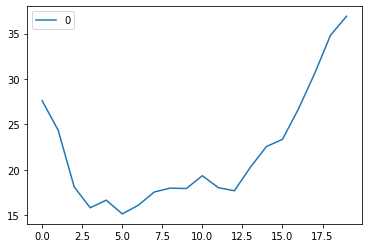

In [21]:
# best K value
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt

#Root Mean Squared Error 
rmse_val = []
final_k = 0
error = 100000.0

for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    cur_error = sqrt(mean_squared_error(y_test,pred))
    if(cur_error < error):
        error=cur_error
        final_k = K
        
    rmse_val.append(cur_error)
    print('RMSE value for k= ' , K , 'is:', cur_error)
    
curve = pd.DataFrame(rmse_val)
curve.plot()
print('Best K value:', final_k)

De notar que este gráfico muda de acordo com o país a prever, pois o dataframe usado será consequentemente diferente.

Caso se queira usar os resultados obtidos no modelo final seria só necessário substituir a porção seguinte por este código :

knn = neighbors.KNeighborsRegressor(n_neighbors = final_k)
No entanto, há uma maneira melhor, mais fácil e mais segura de se fazer esta pesquisa, apesar de ter custos computacionais acrescidos, que é usando a ferramente GridSearchCV, que, como o nome indica, faz uma pesquisa em rede de todos os parâmetros passados e retorna um modelo com o melhor conjunto de parâmetros. neste caso só procuramos pelo parâmetro 'n_neighbor' mas esta pesquisa podia-se extender a todos os outros.

Os valores usados para o procura do K vão de 2 a 15, sendo que não faz sentido fazer com apenas 1 vizinho (mesmo incluída essa hipótese, o próprio GridSearchCV descartaria esse valor) e não existem casos que usufruam de valores K acima de 15. Algumas fontes mencionam apenas usar um número ímpar de vizinhos (algumas indo tão longe como apenas usar um número primo de vizinhos) mas não encontramos, para este caso, provas de que isso nos fosse benéfico, pelo que incluímos todos os valores no intervalo 2 -> 15.

O GridSearchCV tem um parâmetro de cross-validation (cv). Cross-validation serve para verificar o quão generalizável o modelo é, ou seja, qual a taxa de sucesso que terá quando trabalhar com dados fora do seu conjunto de treino. Neste caso usamos o valor recomendado de 10 n_plits, que gerará 9 folds para treino e 1 para teste. Como no caso acima, o random_state serve apenas para garantir que os resultados são reproduzíveis, e para podermos usar esta propriedade o shuffle tinha que estar ativo.

Por último, a métrica usada para a avaliação foi 'r2', maioritariamente pois era a que retornava valores mais fáceis de entender quando ainda não estávamos habituados à leitura dos resultados. O valor do score será então um decimal entre 0 e 1.0, sendo que quanto mais perto de 1.0, melhor o resultado. Obviamente poderiam ser usadas outras métricas como neg_mean_squared_error ou neg_mean_absolute_error, onde, como os valores são negativos, quanto mais perto de 0, melhor o modelo.

In [23]:
# this is another (better) way of getting the right k value
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

params = {'n_neighbors':[2,3,4,5,6,7,8,9,10,11,12,13, 14, 15]}

knn = neighbors.KNeighborsRegressor()
kfold = KFold(n_splits=10, random_state = 7, shuffle=True)

model = GridSearchCV(knn, params, cv=kfold, scoring='r2')
model.fit(x_train,y_train)
print('Score: {}' .format(model.score(x_test, y_test)))
print('Best parameters: {}'.format(model.best_params_))

Score: 0.9972427701765573
Best parameters: {'n_neighbors': 3}



O modelo agora está pronto para uso.

Convém sempre guardar os valores originais (a solução) do país que se pretende prever os casos por milhão para podermos construir gráficos e avaliar o sucesso do modelo obtido. Depois é só correr o modelo sobre o dataset a prever e guardar os resultados obtidos daí.

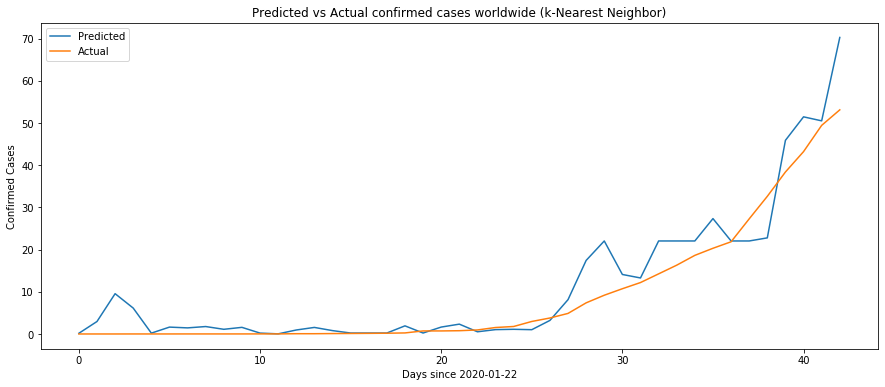

In [24]:
# preserve solution
solution = pred_country
pred_country = pred_country.drop(['cases_per_million'], axis=1)

predict = model.predict(pred_country)
pred_country['cases_per_million'] = predict

fig = plt.figure(figsize=(15,6))
sb.lineplot(x='passed_days', y='cases_per_million', label='Predicted', data=pred_country.groupby(['passed_days'], as_index=False)['cases_per_million'].sum())
ax = sb.lineplot(x='passed_days', y='cases_per_million', label='Actual', data=solution.groupby(['passed_days'], as_index=False)['cases_per_million'].sum())
ax = ax.set(xlabel='Days since 2020-01-22', ylabel='Confirmed Cases', title='Predicted vs Actual confirmed cases worldwide (k-Nearest Neighbor)')